In [144]:
import torch
import torch.nn as nn
from torch.optim import Adam


In [145]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import gymnasium as gym


In [161]:
env = gym.make('CartPole-v1',
               render_mode = 'rgb_array')

In [162]:
class DDQN(nn.Module):

    def __init__(self,n_states,n_actions):
        super().__init__()
        self.n_states = n_states
        self.n_actions = n_actions

        self.network = nn.Sequential(
            nn.Linear(self.n_states,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,self.n_actions)
        )

    def forward(self,states):
         return self.network(states)
            
            

In [163]:
class DDQNAgent:

    def __init__(self,env, n_states, n_actions,n_episodes, gamma=0.9, epsilon = 1, epsilon_dec = 0.995, epsilon_min = 0.01):

        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_episodes = n_episodes
        self.n_actions = n_actions
        self.n_states = n_states
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min

        self.total_steps = 0
        self.lr = 1e-3
        self.memory = deque(maxlen = 20000)
        self.target_update_steps = 2000
        self.batch_size = 64
        self.steps = 0
        self.loss_value = 0

        self.reward_per_10epi = []
        self.epino_forplot = []
        self.all_rewards=[]

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.online_net = DDQN(n_states,n_actions)
        self.online_net.to(self.device)
        self.target_net = DDQN(n_states,n_actions)
        self.target_net.to(self.device)

        self.optimizer = Adam(self.online_net.parameters(),lr=0.001)
        self.loss = nn.SmoothL1Loss() 


    

    def replay_buffer(self):

        if len(self.memory) < self.batch_size:
            return
        if self.total_steps % 8 != 0:
            return

        

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, done = zip(*batch)
            #.unsqueeze(dim) adds a dimension of size 1 at the specified dim index.
           #.unsqueeze(1) = shape (B,1)
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        done = torch.tensor(done, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)


        qValues = self.online_net(states).gather(1,actions)

        with torch.no_grad():
            next_actions = self.online_net(next_states).argmax(1, keepdim=True)       #choose next_actions based on online net
            next_q_values = self.target_net(next_states).gather(1, next_actions)     #get q value of next_action using target net
            target_qValues = rewards + self.gamma * next_q_values * (1 - done)       #compute target q values

        
        loss = self.loss(qValues, target_qValues)
        self.loss_value += loss.item()
        self.optimizer.zero_grad()   #clears old gradiants
        loss.backward()      #backpropagation
        nn.utils.clip_grad_norm_(self.online_net.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.steps += 1
        
        if self.steps % self.target_update_steps == 0:
            self.target_net.load_state_dict(self.online_net.state_dict())
        

    

    def select_action(self,state):

        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            state = torch.tensor(state).unsqueeze(0).to(self.device)  # 0 convers (4,) to (1,4) (single batch of states)
                                                                      
            with torch.no_grad(): #no grad means dont update parameters
                qVals = self.online_net(state)
            return torch.argmax(qVals).item()

    # Reward Clipping
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        theta = obs[2]
    
        reward -= 2.0 * abs(theta)   # soft angle penalty
        return obs, reward, terminated, truncated, info
                
            

    def train(self):

        for episode in range(self.n_episodes):
            state, _ = self.env.reset()
            state = state
            total_reward = 0
            done = False
            

            
            while not done:

                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.step(action)
    
                #next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                # print(next_state.shape)
                next_state = next_state
                # print(next_state.shape)
                total_reward += reward

                self.memory.append((state, action, reward, next_state, done))

                state = next_state
                
                self.replay_buffer()

                
            self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_dec)
            self.all_rewards.append(total_reward)

            if episode%10 == 0:
                self.epino_forplot.append(episode)
                avg_reward = np.mean(self.all_rewards[-10:])
                self.reward_per_10epi.append(avg_reward)
                
            if episode%50 ==0:
                print(f"Episode {episode}, Reward {np.mean(self.all_rewards[-50:])}, Epsilon {self.epsilon:.4f}")
            

                
    def plot(self):
        plt.plot(self.epino_forplot, self.reward_per_10epi)
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("Double DQN Training Progress")
        plt.show()
                

    

In [164]:
Agent = DDQNAgent(env,4,2,1000)
Agent.train()

Episode 0, Reward 22.687557220458984, Epsilon 0.9950
Episode 50, Reward 16.007030487060547, Epsilon 0.7744
Episode 100, Reward 25.38713836669922, Epsilon 0.6027
Episode 150, Reward 42.89723205566406, Epsilon 0.4691
Episode 200, Reward 160.90614318847656, Epsilon 0.3651
Episode 250, Reward 370.8710632324219, Epsilon 0.2842
Episode 300, Reward 431.12530517578125, Epsilon 0.2212
Episode 350, Reward 445.3057861328125, Epsilon 0.1721
Episode 400, Reward 457.03472900390625, Epsilon 0.1340
Episode 450, Reward 485.2973937988281, Epsilon 0.1043
Episode 500, Reward 474.0552062988281, Epsilon 0.0812
Episode 550, Reward 470.4667053222656, Epsilon 0.0632
Episode 600, Reward 492.0417175292969, Epsilon 0.0492
Episode 650, Reward 486.3038635253906, Epsilon 0.0383
Episode 700, Reward 482.7940979003906, Epsilon 0.0298
Episode 750, Reward 494.9906921386719, Epsilon 0.0232
Episode 800, Reward 495.3116149902344, Epsilon 0.0180
Episode 850, Reward 491.1792907714844, Epsilon 0.0140
Episode 900, Reward 491.68

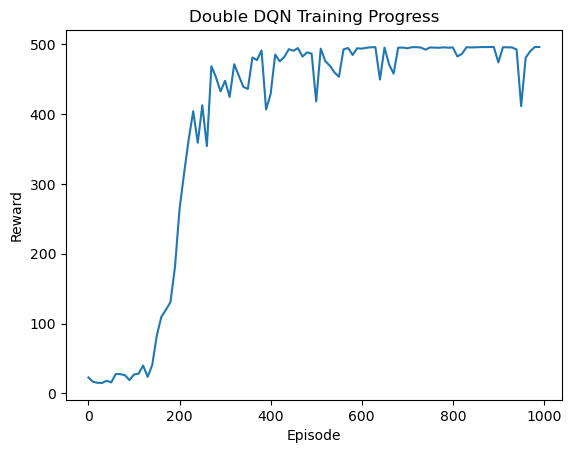

In [165]:
Agent.plot()

In [166]:
torch.save(Agent.online_net.state_dict(), "Double-DQN-Online_net.pth")

In [168]:
env = gym.make("CartPole-v1", render_mode = "human")
for i in range(3):
    state, _ = env.reset()
    done = False
    online_net = Agent.online_net
    online_net.eval()
    total_reward = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    while not done:
        env.render()
        with torch.no_grad():
            state = torch.tensor(state).unsqueeze(0).to(device)
            action = torch.argmax(online_net(state)).item()
        next_state, reward, term, trun, _  = env.step(action)
        total_reward += reward
        done = term or trun
        state = next_state
    print("Total reward this episode: ",total_reward)
env.close()

Total reward this episode:  500.0
Total reward this episode:  500.0
Total reward this episode:  500.0
